In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## create basis & function demo

In [2]:
np.random.seed(1234567)

In [3]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean


In [4]:
import math 
def cos(x):
    return(-10+(5-x)**2)/20

t: [ 0.   0.   0.   2.5  5.   7.5 10.  10.  10. ]
c: [ 0.75   0.125 -0.5   -0.5    0.125  0.75   0.     0.     0.   ]
k: 2



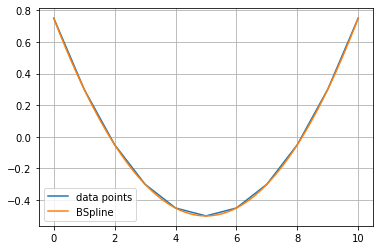

In [5]:
degree =2
x = np.array(range(0, 11))
y = np.array([cos(i) for i in x])
z= [cos(i/10) for i in np.array(range(0, 110))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

## create data

In [6]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean


In [7]:
def data_create(seed,time_stamp):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  y = np.array([cos(i) for i in x]) #generate coefficient

  base_DAG=np.zeros((5, 5))
  base_DAG[0,4]=y[0]##edited to be coeffcient with error
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[0,4]=y[i]
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
  return X_all

In [9]:
n = 30 # The number of samples of data.
d = 5 # The number of variables in data.
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
n_times=30
seed_list=np.random.randint(1, 1000000, size=n_times)
seed=seed_list[0]
X_all=data_create(seed,time_stamp) #create data

In [10]:
seed_list

array([913812, 374400, 343669, 289095, 235846, 432099, 448097, 384097,
       134030, 454991, 401627,  97188, 615884, 585262, 902641, 897795,
       678150, 361884, 928159, 446640,  26580, 865407, 789523, 704840,
       359269,  38248, 809111, 137636, 698530, 230177])

## piecewise ANOCA

In [11]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random

import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed


In [12]:
def train(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            h1_B = fun_h1_B(origin_B)
            h2_B = fun_h2_B(origin_B)

            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


import times

In [13]:
import time

In [15]:
n = 30 # The number of samples of data.
d = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
n_var=5

n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list=np.zeros((n_times,time_stamp,n_var,n_var))
B_list=np.zeros((n_times,d, d))
FDR_total=[]
TPR_total=[]
SHD_total=[]
time_list=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  print(seed)
  X_all=data_create(seed,time_stamp) #create data
  average_list=np.zeros((time_stamp,d, d))
  FDR_list_piece=[]
  TPR_list_piece=[]
  SHD_list_piece=[]
  base_DAG=np.zeros((5, 5))
  ####estimate at each time_stamp####
  timestart=time.time()
  for j in range(time_stamp):
  # ----------- Configurations:
      k_max_iter = int(1e2) # The max iteration number for searching parameters.
      original_lr = 3e-3  # Initial learning rate.
      encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      temp = 0.5 # Temperature for Gumbel softmax.
      factor = True # Factor graph model.
      encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      tau_B = 0. # Coefficient for L-1 norm of matrix B.
      lambda1 = 0. # Coefficient for DAG constraint h1(B).
      lambda2 = 0. # Coefficient for identification constraint h2(B).
      c_B = 1 # Coefficient for absolute value h1(B).
      d_B = 1 # Coefficient for absolute value h2(B).
      h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
      h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
      lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
      gamma = 1.0 # LR decay factor. 
      ######################


      X=X_all[(j*30):(j*30+30),:]


      np.random.seed(seed)
      random.seed(seed)
      torch.manual_seed(seed)
      feat_train = torch.FloatTensor(X)
      feat_valid = torch.FloatTensor(X)
      feat_test = torch.FloatTensor(X)

      # Reconstruct itself
      train_data = TensorDataset(feat_train, feat_train)
      valid_data = TensorDataset(feat_valid, feat_train)
      test_data = TensorDataset(feat_test, feat_train)

      train_loader = DataLoader(train_data, batch_size = batch_size)
      valid_loader = DataLoader(valid_data, batch_size = batch_size)
      test_loader = DataLoader(test_data, batch_size = batch_size)

      # ----------- Load modules:
      off_diag = np.ones([d, d]) - np.eye(d) # Generate off-diagonal interaction graph
      rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
      rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
      rel_rec = torch.DoubleTensor(rel_rec)
      rel_send = torch.DoubleTensor(rel_send)
      adj_A = np.zeros((d, d)) # Add adjacency matrix

      encoder = MLPEncoder(d * x_dims, x_dims, encoder_hidden,
                              int(z_dims), adj_A,
                              batch_size = batch_size,
                              do_prob = encoder_dropout, factor = factor).double()
      decoder = MLPDecoder(d * x_dims,
                              z_dims, x_dims, encoder,
                              data_variable_size = d,
                              batch_size = batch_size,
                              n_hid=decoder_hidden,
                              do_prob=decoder_dropout).double()

      # ----------- Set up optimizer:
      optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
      scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                      gamma = gamma)

      rel_rec = Variable(rel_rec)
      rel_send = Variable(rel_send)

      # ----------- Main:
      best_ELBO_loss = np.inf
      best_NLL_loss = np.inf
      best_MSE_loss = np.inf
      h1_B_new = torch.tensor(1.)
      h2_B_new = 1
      h1_B_old = np.inf
      h2_B_old = np.inf
      lr = original_lr

      try:
          for step_k in range(k_max_iter):
              while c_B * d_B < 1e+20:
                  for epoch in range(epochs):
                      old_lr = lr 
                      ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr)

                      if ELBO_loss < best_ELBO_loss:
                          best_ELBO_loss = ELBO_loss

                      if NLL_loss < best_NLL_loss:
                          best_NLL_loss = NLL_loss

                      if MSE_loss < best_MSE_loss:
                          best_MSE_loss = MSE_loss

                  if ELBO_loss > 2 * best_ELBO_loss:
                      break

                  # Update parameters
                  B_new = origin_B.data.clone()
                  h1_B_new = fun_h1_B(B_new)
                  h2_B_new = fun_h2_B(B_new)
                  if h1_B_new.item() > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      c_B *= 10
                      d_B *= 10
                  elif h1_B_new.item() > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                      c_B *= 10
                  elif h1_B_new.item() < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      d_B *= 10
                  else:
                      break

              # Update parameters    
              h1_B_old = h1_B_new.item()
              h2_B_old = h2_B_new
              lambda1 += c_B * h1_B_new.item()
              lambda2 += d_B * h2_B_new

              if h1_B_new.item() <= h1_tol and h2_B_new <= h2_tol:
                  break

      except KeyboardInterrupt:
          print('KeyboardInterrupt')

      predB = np.matrix(origin_B.data.clone().numpy())
      print('Best ELBO Loss :', best_ELBO_loss)
      print('Best NLL Loss :', best_NLL_loss)
      print('Best MSE Loss :', best_MSE_loss)
      #calculate_effect(predB)
      print(j)
      average_list[j,:,:]=predB
      #FDR, TPR, SHD
      base_DAG[0,4]=cos(j)
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=abs(predB)
      a[a<0.4] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)



  average_coef_list[replicate,:,:,:]=average_list #average coef save to matrix
  np.save("quadra_10_30_ANOCA",average_coef_list)
  FDR_total.append(mean(FDR_list_piece))
  TPR_total.append(mean(TPR_list_piece))
  SHD_total.append(mean(SHD_list_piece))
  timeend=time.time()
  time_list.append(timeend-timestart)
  #####write at every epoch
  df = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df["FDR"]=FDR_total
  df["TPR"]=TPR_total
  df["SHD"]=SHD_total
  df["time"]=time_list
  #df.to_csv("cos_rep10.csv")
  print(replicate)

913812


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0008666900919097248
Best NLL Loss : 2.9408539417944714e-06
Best MSE Loss : 1.1763415767177888e-06
0
Best ELBO Loss : 0.0010375961565224174
Best NLL Loss : 2.3431152047429383e-06
Best MSE Loss : 9.372460818971755e-07
1
Best ELBO Loss : 0.0007172442242579296
Best NLL Loss : 1.1937854663570226e-06
Best MSE Loss : 4.775141865428092e-07
2
Best ELBO Loss : 0.000987210965158249
Best NLL Loss : 2.6842275136994995e-06
Best MSE Loss : 1.0736910054797993e-06
3
Best ELBO Loss : 0.0008972870561138909
Best NLL Loss : 2.475291676778531e-06
Best MSE Loss : 9.901166707114123e-07
4
Best ELBO Loss : 0.00109961746340621
Best NLL Loss : 3.8875259236775516e-06
Best MSE Loss : 1.5550103694710208e-06
5
Best ELBO Loss : 0.0009157477585176695
Best NLL Loss : 2.0187972425735836e-06
Best MSE Loss : 8.075188970294333e-07
6
Best ELBO Loss : 0.0007855837019902626
Best NLL Loss : 3.2404914454462825e-06
Best MSE Loss : 1.2961965781785129e-06
7
Best ELBO Loss : 0.0009014797832237255
Best NLL Loss : 1

Best ELBO Loss : 0.0016709769686480192
Best NLL Loss : 1.8797258345049285e-05
Best MSE Loss : 7.518903338019715e-06
0
Best ELBO Loss : 0.0009533024912797004
Best NLL Loss : 3.00425819130265e-06
Best MSE Loss : 1.2017032765210603e-06
1
Best ELBO Loss : 0.0006595144361247456
Best NLL Loss : 8.480078652582857e-07
Best MSE Loss : 3.392031461033143e-07
2
Best ELBO Loss : 0.0011307716149302099
Best NLL Loss : 2.2202262192563785e-06
Best MSE Loss : 8.880904877025514e-07
3
Best ELBO Loss : 0.0015538698461124367
Best NLL Loss : 1.7241093916315134e-05
Best MSE Loss : 6.896437566526052e-06
4
Best ELBO Loss : 0.0015102725416025556
Best NLL Loss : 1.2210067102994107e-05
Best MSE Loss : 4.884026841197643e-06
5
Best ELBO Loss : 0.0011865276845419764
Best NLL Loss : 3.1616274387759505e-06
Best MSE Loss : 1.2646509755103802e-06
6
Best ELBO Loss : 0.0009269915968505493
Best NLL Loss : 5.240059959237185e-06
Best MSE Loss : 2.096023983694874e-06
7
Best ELBO Loss : 0.0005974345321823323
Best NLL Loss : 1.4

Best ELBO Loss : 0.0016599833965048403
Best NLL Loss : 6.475329596426604e-05
Best MSE Loss : 2.5901318385706422e-05
0
Best ELBO Loss : 0.0010053094677922277
Best NLL Loss : 2.4351933635698704e-06
Best MSE Loss : 9.740773454279484e-07
1
Best ELBO Loss : 0.0011920657312675257
Best NLL Loss : 2.4382435699843554e-06
Best MSE Loss : 9.752974279937421e-07
2
Best ELBO Loss : 0.0009054628823493258
Best NLL Loss : 1.8314430712388828e-06
Best MSE Loss : 7.325772284955531e-07
3
Best ELBO Loss : 0.0010155632936788973
Best NLL Loss : 2.8910758196890518e-06
Best MSE Loss : 1.1564303278756208e-06
4
Best ELBO Loss : 0.0009273360857196231
Best NLL Loss : 1.8589529942661529e-06
Best MSE Loss : 7.435811977064612e-07
5
Best ELBO Loss : 0.001207021762320913
Best NLL Loss : 2.6634570530785923e-06
Best MSE Loss : 1.0653828212314368e-06
6
Best ELBO Loss : 0.001257730879937737
Best NLL Loss : 2.5603823157587696e-06
Best MSE Loss : 1.024152926303508e-06
7
Best ELBO Loss : 0.001380322829189257
Best NLL Loss : 2.

Best ELBO Loss : 0.0009592770675668955
Best NLL Loss : 5.9613013631215644e-06
Best MSE Loss : 2.384520545248626e-06
0
Best ELBO Loss : 0.0009792510253032077
Best NLL Loss : 3.441391915024105e-06
Best MSE Loss : 1.3765567660096422e-06
1
Best ELBO Loss : 0.0008842240479743508
Best NLL Loss : 1.6734418089293078e-06
Best MSE Loss : 6.69376723571723e-07
2
Best ELBO Loss : 0.0012782139739918646
Best NLL Loss : 2.8006874476336052e-06
Best MSE Loss : 1.1202749790534421e-06
3
Best ELBO Loss : 0.0011145796214860892
Best NLL Loss : 5.408960986010305e-06
Best MSE Loss : 2.1635843944041222e-06
4
Best ELBO Loss : 0.0011877245559367186
Best NLL Loss : 6.131416598435953e-06
Best MSE Loss : 2.452566639374381e-06
5
Best ELBO Loss : 0.0010240550598489368
Best NLL Loss : 1.5410034656207849e-06
Best MSE Loss : 6.164013862483139e-07
6
Best ELBO Loss : 0.0007866130429448031
Best NLL Loss : 2.3257278894476365e-06
Best MSE Loss : 9.302911557790544e-07
7
Best ELBO Loss : 0.0010101121492100981
Best NLL Loss : 4.

Best ELBO Loss : 0.0016773360914654797
Best NLL Loss : 1.6368032682953366e-06
Best MSE Loss : 6.547213073181347e-07
0
Best ELBO Loss : 0.001557329072472253
Best NLL Loss : 3.5534041302127947e-06
Best MSE Loss : 1.4213616520851176e-06
1
Best ELBO Loss : 0.001688858829265599
Best NLL Loss : 3.850505708667782e-06
Best MSE Loss : 1.540202283467113e-06
2
Best ELBO Loss : 0.0022393420291789722
Best NLL Loss : 5.272190210620914e-06
Best MSE Loss : 2.108876084248365e-06
3
Best ELBO Loss : 0.002685215266757586
Best NLL Loss : 1.1898606255441731e-05
Best MSE Loss : 4.759442502176693e-06
4
Best ELBO Loss : 0.0015130906021870046
Best NLL Loss : 4.776147187205148e-06
Best MSE Loss : 1.9104588748820593e-06
5
Best ELBO Loss : 0.0015171075155714986
Best NLL Loss : 4.926532508573407e-06
Best MSE Loss : 1.9706130034293628e-06
6
Best ELBO Loss : 0.0017063244584679764
Best NLL Loss : 3.4343657070828257e-06
Best MSE Loss : 1.3737462828331306e-06
7
Best ELBO Loss : 0.0026364742017745075
Best NLL Loss : 1.33

In [38]:
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
df["time"]=time_list

df

,FDR,TPR,SHD,time
0,0.258333,0.90,0.75,718.534061
1,0.337500,0.65,1.45,672.521675
2,0.058333,0.65,0.50,725.070246
3,0.337500,0.65,1.35,716.542320
4,0.075000,0.65,0.45,724.934847
5,0.000000,0.65,0.35,748.936342
6,0.133333,0.65,0.60,765.518650
7,0.087500,0.75,0.50,743.192097
8,0.283333,0.70,1.20,739.361321
9,0.204167,0.65,0.80,727.557208


In [58]:
df.mean()

FDR       0.121667
TPR       0.670000
SHD       0.655000
time    730.358560
dtype: float64

In [56]:
average_coef_list[:,:,0,4].shape

(20, 20)

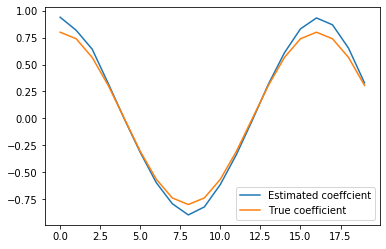

In [57]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,0,4],0))
plt.plot(range(time_stamp),[cos(i) for i in range(time_stamp)])
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

# new method

In [47]:
# ----------- Configurations:
#time_stamp=10
n_timestamp=time_stamp
sample__time=30
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [48]:
n_timestamp

20

In [49]:
sample__time

30

In [50]:
def create_X(X):
    X_sum=np.zeros((sample__time, n_var,1))
    for i in range(0,n_timestamp):
        X_sum=X_sum+X[(sample__time*i):(sample__time*(i+1)),:] #sum i
        print((sample__time*i),(sample__time*(i+1)))
    return(X_sum)

In [51]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_sum=np.zeros((sample__time, n_var,1))
        for i in range(0,n_timestamp):
            D_sum=D_sum+X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#sum X_i *f(i)
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_sum
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [52]:
def spl_const(x):
    return(1)

In [53]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5]

In [54]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [55]:
# ----------- Configurations:
n = 30 # The number of samples of data.
d = 30 # The number of variables in data after spline.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [56]:
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:,:p]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0])) # uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [57]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [58]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:,:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [59]:
n_var=5
n_times=50 #no. of replicates
time_stamp=20 #no. of timestamp
np.random.seed(1234567) #Random seed
#seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp))
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
time_list_new=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp) #create data
  X_left=create_X(X_all)
  D=create_D(X_all,spline_list)
  data_all=np.append(X_left,D, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = 30 # The number of samples of data.
  d = 30 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=5 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              for i in range(n_timestamp):
                  #aa=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p),B_new[p:,:p]))#acyclity on Gamma
                  #print(aa)
                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:,:p].type(torch.FloatTensor))))
                  #h1_B=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),B_new[p:,:p].type(torch.FloatTensor)))#acyclity on Gamma
              h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top
              #B_trans_new=torch.transpose(B_new, 0, 1)
              #h1_B = fun_h1_B(B_trans_new[p:,p:]) #acyclity on G
              #h1_B = fun_h1_B(B_new[p:,:p]) #edited acyclity on G
              #h2_B = fun_h3_B(B_new) ##handle the zero

              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:,:(p)]
  def matrix_gen(t):
    output,identity=spl_consraint(spline_list,t,p)
    return torch.matmul(identity.type(torch.FloatTensor),torch.from_numpy((np.multiply(output.numpy(),pred_gamma))).type(torch.FloatTensor)).T
  estimated_coefficient=[matrix_gen(i)[4,0].item() for i in range(time_stamp)]
  average_coef_list_new[replicate,:]=estimated_coefficient
  ## FDR, TPR, SHD for  new method
  FDR_list_piece_new=[]
  TPR_list_piece_new=[]
  SHD_list_piece_new=[]
  base_DAG=np.zeros((5, 5))
  for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=abs(matrix_gen(i).numpy())
      a[a<0.4] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
  FDR_total_new.append(mean(FDR_list_piece_new))
  TPR_total_new.append(mean(TPR_list_piece_new))
  SHD_total_new.append(mean(SHD_list_piece_new))
  timeend_new=time.time()
  time_list_new.append(timeend_new-timestart_new)
  ###write csv
  df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df_new["FDR"]=FDR_total_new
  df_new["TPR"]=TPR_total_new
  df_new["SHD"]=SHD_total_new
  df_new["time"]=time_list_new
  df_new.to_csv("cos_new.csv")
  print(replicate)


0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.07818287436407118
Best NLL Loss : 0.00021279066160837757
Best MSE Loss : 1.4186044107225167e-05
0
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.0984414308999451
Best NLL Loss : 0.00039596808298519425
Best MSE Loss : 2.6397872199012946e-05
1
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.08315984828255162
Best NLL Loss : 0.00028355952984412513
Best MSE Loss : 1.8903968656275005e-05
2
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.12237789599855997
Best NLL Loss : 0.0008859617627780455
Best MSE Loss : 5.906411751853639e-05
3
0 30
30 60
60 90
90 120
120 150
150 180
180

Best ELBO Loss : 0.09868114374913076
Best NLL Loss : 0.0010275994970294787
Best MSE Loss : 6.850663313529857e-05
30
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.14827845443716678
Best NLL Loss : 0.0019834125739774215
Best MSE Loss : 0.00013222750493182815
31
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.17812195206444653
Best NLL Loss : 0.0008209064051833654
Best MSE Loss : 5.472709367889105e-05
32
0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
(30, 30, 1)
Best ELBO Loss : 0.1582256576052697
Best NLL Loss : 0.0013182547737119476
Best MSE Loss : 8.78836515807965e-05
33
0 30
30 60
60 90
90 120
120 150
150 180
180 2

In [60]:
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
df_new["time"]=time_list_new

df_new

,FDR,TPR,SHD,time
0,0.525000,0.80,1.05,381.492618
1,0.125000,0.85,0.35,354.007478
2,0.433333,0.60,1.10,385.113245
3,0.416667,0.70,1.10,349.456397
4,0.000000,0.70,0.30,350.032473
5,0.550000,0.75,1.25,349.297524
6,0.000000,0.70,0.30,355.798350
7,0.000000,0.70,0.30,359.698214
8,0.225000,0.85,0.55,412.924551
9,0.000000,0.70,0.30,346.573471


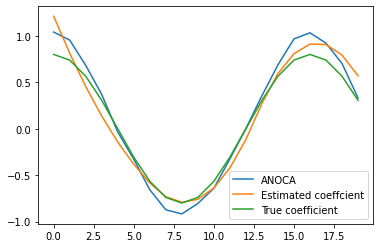

In [61]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list,0))
plt.plot(range(time_stamp),np.mean(average_coef_list_new,0))
plt.plot(range(time_stamp),[cos(i) for i in range(time_stamp)])

# Function add a legend  
plt.legend(["ANOCA","Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

In [62]:
df_new.mean()##new method

FDR       0.09550
TPR       0.66500
SHD       0.50100
time    357.62665
dtype: float64

In [63]:
df_new.std()

FDR      0.178255
TPR      0.182178
SHD      0.364844
time    19.318386
dtype: float64

In [64]:
df.mean() ## ANOCA

FDR       0.177833
TPR       0.706000
SHD       0.769000
time    660.472313
dtype: float64

In [65]:
df.std() ## ANOCA

FDR      0.147714
TPR      0.065962
SHD      0.417706
time    32.956139
dtype: float64